# Telecom Final

### Objective: To determine the difference in cost if clients pick a different plan

### Data Description 

The datasets contain data on the use of the virtual telephony service CallMeMaybe. Its clients are organizations that need to distribute large numbers of incoming calls among various operators, or make outgoing calls through their operators. Operators can also make internal calls to communicate with one another. These calls go through CallMeMaybe's network.

The zipped dataset `telecom_dataset_us.csv` contains the following columns:

- `user_id` — client account ID
- `date` — date the statistics were retrieved
- `direction` — call direction (`out` for outgoing, `in` for incoming)
- `internal` — whether the call was internal (between a client's operators)
- `operator_id` — operator identifier
- `is_missed_call` — whether the call was missed
- `calls_count` — number of calls
- `call_duration` — call duration (excluding waiting time)
- `total_call_duration` — call duration (including waiting time)

 

The dataset `telecom_clients_us.csv` has the following columns:

- `user_id`
- `tariff_plan` — client's current plan
- `date_start` — client's registration date

## Step 1. Import the data

In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests


In [350]:
spreadsheet_id = '16KZxI-z2rJu3xntR1S9JAGRJeXK6T-3sIFRNs5I36L0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
clients_df = pd.read_csv(BytesIO(r.content))

spreadsheet_id = '1DvZHCu5hJDu6mC9RwowjKypuQWni59g6Ucmh5zkoAqk'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))

In [351]:
#Load clients dataframe
display(clients_df.info())
display(clients_df.head())
display(clients_df.sample())
display(clients_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


None

user_id tariff_plan  date_start
0   166713           A   8/15/2019
1   166901           A   8/23/2019
2   168527           A  10/29/2019
3   167097           A    9/1/2019
4   168193           A  10/16/2019

user_id tariff_plan date_start
569   167947           B  10/7/2019

user_id
count     732.000000
mean   167431.927596
std       633.810383
min    166373.000000
25%    166900.750000
50%    167432.000000
75%    167973.000000
max    168606.000000

- There are 732 entries under clients data frame
- There are no duplicate values
- We have to change the date column to its right data type


In [352]:
#Load telecom dataframe
display(df.info())
display(df.head())
display(df.sample())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


None

user_id                       date direction internal  operator_id  \
0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   

   is_missed_call  calls_count  call_duration  total_call_duration  
0            True            2              0                    4  
1            True            3              0                    5  
2            True            1              0                    1  
3           False            1             10                   18  
4            True            3              0                   25

user_id                       date direction internal  operator_id  \
35467   167532  2019-10-22 00:00:00+03:00        in    False          NaN   

       is_missed_call  calls_count  call_duration  total_call_duration  
35467            True            5              0                  110

user_id    operator_id   calls_count  call_duration  \
count   53902.000000   45730.000000  53902.000000   53902.000000   
mean   167295.344477  916535.993002     16.451245     866.684427   
std       598.883775   21254.123136     62.917170    3731.791202   
min    166377.000000  879896.000000      1.000000       0.000000   
25%    166782.000000  900788.000000      1.000000       0.000000   
50%    167162.000000  913938.000000      4.000000      38.000000   
75%    167819.000000  937708.000000     12.000000     572.000000   
max    168606.000000  973286.000000   4817.000000  144395.000000   

       total_call_duration  
count         53902.000000  
mean           1157.133297  
std            4403.468763  
min               0.000000  
25%              47.000000  
50%             210.000000  
75%             902.000000  
max          166155.000000

- There are about 53902 mobile user logs
- There are 8172 missing values under operator Id column and 117 missing values under internal column
- Columns: `date` and `operator_id` needs to be changed to their right data types
 
 

## Step 2. Data Preprocessing

### Clients

In [353]:
#rename column
clients_df = clients_df.rename(columns= {'date_start': 'start_date'})

#Change date data type
clients_df['start_date'] = pd.to_datetime(clients_df['start_date'], format="%m/%d/%Y" )

#Check for duplicates
display(clients_df.duplicated().sum())

#Check for nulls
display(clients_df.isnull().sum())

0

user_id        0
tariff_plan    0
start_date     0
dtype: int64

### Telecom data frame

In [354]:
#Change columns to their right data types
df['date'] = df['date'].astype('datetime64[D]')
df['month'] = df['date'].astype('datetime64[M]')

#Checking for duplicates
display(df.duplicated().sum())

#Dropping dupclicates 
df.drop_duplicates(inplace=True)


4900

We have 4900 duplicate entries which is 9% of the data. The duplicate entries are not that many so we decided to drop them.

### Missing Values

In [355]:
#Count missing values
print('\033[1m','Missing Values','\033[0m')
display(df.isnull().sum())

#Check unique users that are missing operator_id
print('\033[1m','Checking one user_id with missing operator_id','\033[0m')
display(df.loc[df['operator_id'].isnull()]['user_id'].head())

#Check how many operator_id under this user_id
print('\033[1m', 'Operator_ids with this user_id','\033[0m')
df.loc[df['user_id']== 166377]['operator_id'].value_counts() 

 Missing Values 


user_id                   0
date                      0
direction                 0
internal                110
operator_id            7456
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
month                     0
dtype: int64

 Checking one user_id with missing operator_id 


0     166377
7     166377
9     166377
17    166377
27    166377
Name: user_id, dtype: int64

 Operator_ids with this user_id 


880028.0    202
880026.0    182
880022.0     70
880020.0     20
881278.0      8
Name: operator_id, dtype: int64

In [356]:
#Filling in missing values for operator_id
df['operator_id'] = df.groupby(['date','user_id'])['operator_id'].apply(lambda x:x.fillna(x.ffill().bfill()))

#Dropping the rest of the missing values
df.dropna(subset=['operator_id', 'internal'], inplace=True)

#Changing the data type for operator_id
df['operator_id'] = df['operator_id'].astype(int)

There are about 7456 missing values from `operator_id` column which is about 14% of the dataset. We can deal with missing values by matching `user_id` with `operator_id`. We can fill the missing values using *ffill* and _bbfill_ as long as the call happened within the same day. We can drop the remaining null values in `operator_id` and `user_id` column as it is not much.

## Exploratory Data Analysis

In [357]:
df.describe()

user_id    operator_id   calls_count  call_duration  \
count   47084.000000   47084.000000  47084.000000   47084.000000   
mean   167294.901962  916309.010874     16.968609     901.409608   
std       597.740752   21149.126967     64.810312    3847.533475   
min    166377.000000  879896.000000      1.000000       0.000000   
25%    166782.000000  900614.000000      1.000000       0.000000   
50%    167172.000000  913788.000000      4.000000      51.000000   
75%    167816.000000  937156.000000     13.000000     613.000000   
max    168606.000000  973286.000000   4817.000000  144395.000000   

       total_call_duration  
count         47084.000000  
mean           1202.081408  
std            4535.358846  
min               0.000000  
25%              54.000000  
50%             232.000000  
75%             954.000000  
max          166155.000000

### Call Direction Distribution

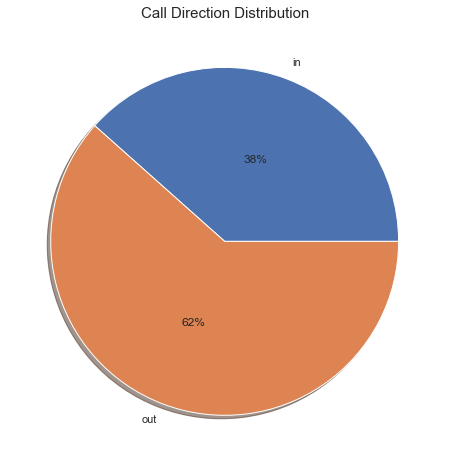

In [359]:
ax = df.groupby('direction')['operator_id'].count().plot(y='operator_id', kind='pie',figsize=(8,8), autopct='%1.0f%%'\
                                                       ,pctdistance=0.5,shadow=True)
plt.ylabel("")
plt.title('Call Direction Distribution',fontsize=15)
plt.show()

About 62% are outgoing calls and 38% are incoming calls.

### Internal and External Call Share

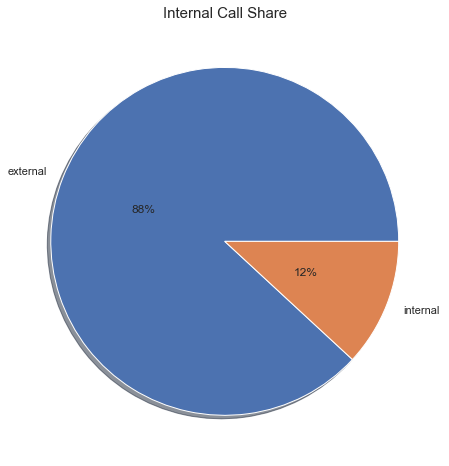

In [360]:
labels = ['external', 'internal']
ax= df.groupby('internal')['operator_id'].count().plot(y='operator_id', kind='pie',figsize=(8,8), autopct='%1.0f%%'\
                                                       ,pctdistance=0.5,shadow=True, labels=labels)
plt.title('Internal Call Share',fontsize=15)
plt.ylabel("")
plt.show()

Most calls are external calls which are at 88% and internal calls are at 12%.

### Operators per User

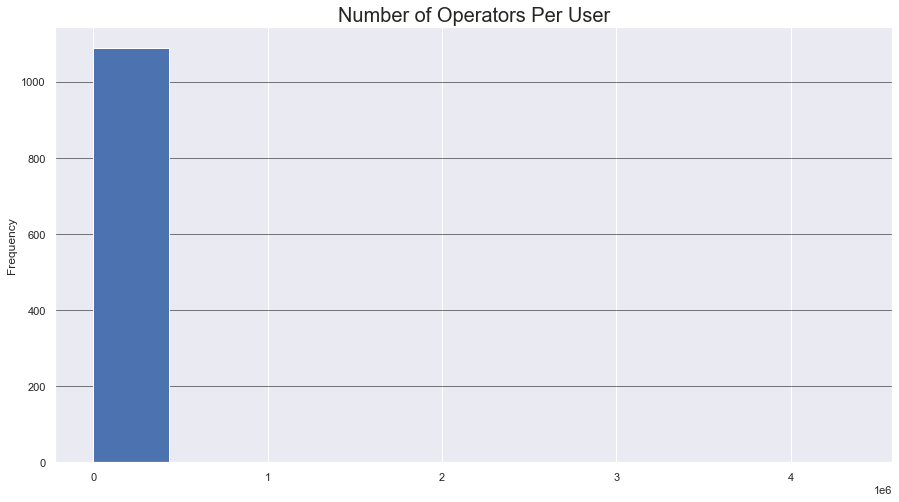

In [361]:
ax = df.groupby('operator_id').call_duration.sum().plot(figsize=(15,8), kind='hist',bins=10)
ax.set_title('Number of Operators Per User', fontsize=20)
ax.grid(axis='y', color='black', alpha=0.5)
plt.show()

### Call Duration

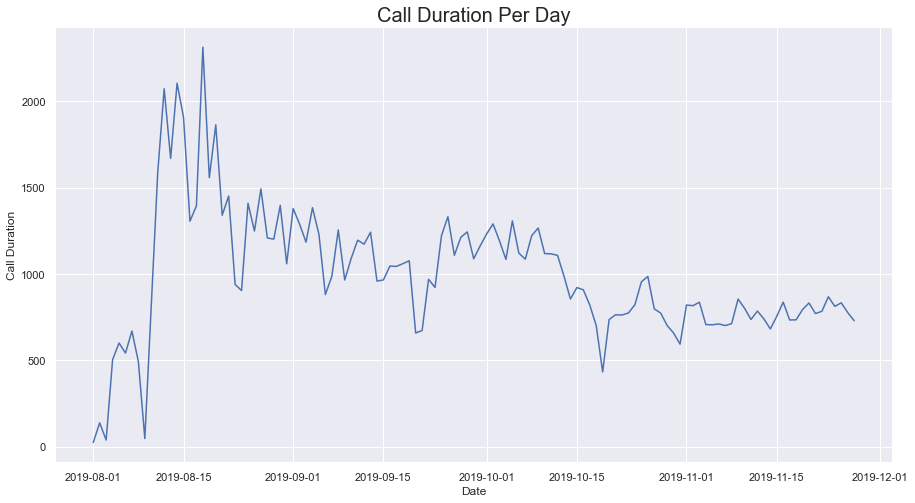

In [362]:
sns.set(rc={'figure.figsize':(15,8)})
#sns.set(style='darkgrid')
sns.lineplot(data=df,x='date',y='call_duration',ci=None)
plt.title('Call Duration Per Day', fontsize =20)
plt.ylabel('Call Duration')
plt.xlabel('Date')
plt.show()

Client operator's call duration fluctuated throughout the month. Highest call duration occured the end of August.

### Missed Calls 

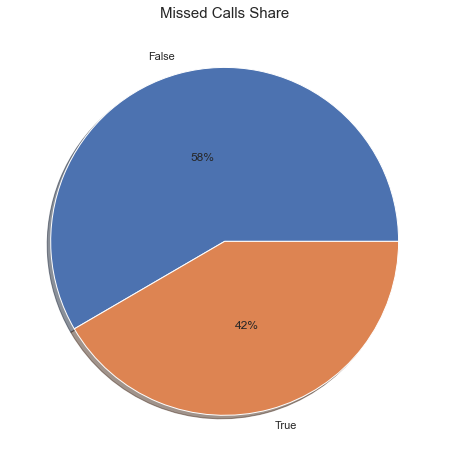

In [363]:
ax= df.groupby('is_missed_call')['operator_id'].count().plot(y='operator_id', kind='pie',figsize=(8,8),\
                                                             autopct='%1.0f%%',pctdistance=0.5,shadow=True)
plt.ylabel("")
plt.title('Missed Calls Share',fontsize=15)
plt.show()

Missed calls are about 42% which is a large amount for the total number of calls. Column `is_missed_call` has inaccurate values. It's showing the `call_duration` is not 0 even though it was a missed call. We replaced these with 0.

In [364]:
#Replace call duration on missed calls
df.loc[(df['is_missed_call'] == True) & (df['call_duration'] >0),'call_duration']=0

### Calls per day

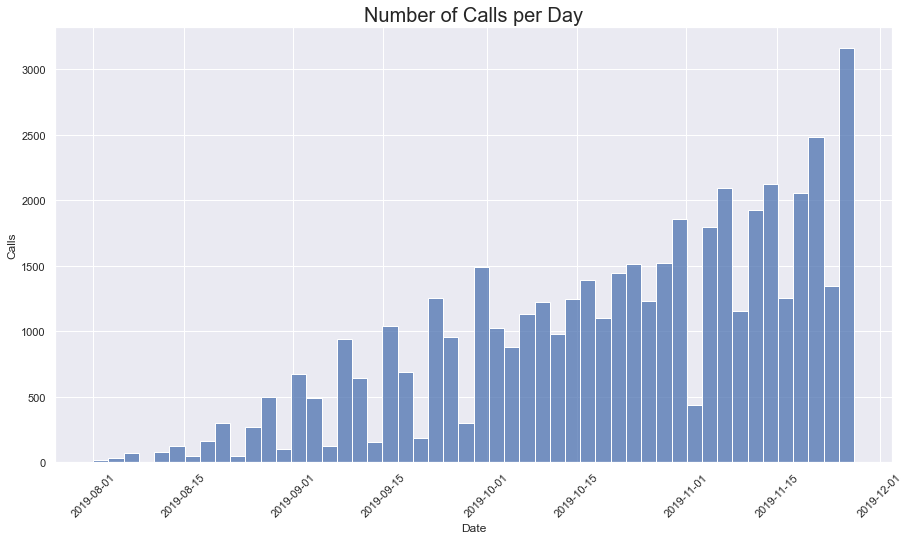

In [365]:
plt.figure(figsize=(15,8))
sns.set(style='darkgrid')
sns.histplot(df['date'], bins=50).set_title('Number of Calls per Day', fontsize=20)
plt.ylabel('Calls')
plt.xticks(rotation='45')
plt.xlabel('Date')
plt.show()

As we can see, there were not a lot of user activities in the month of August. Calls increased by October and it continued until November with the highest activity at the end of November.

### Operators per user

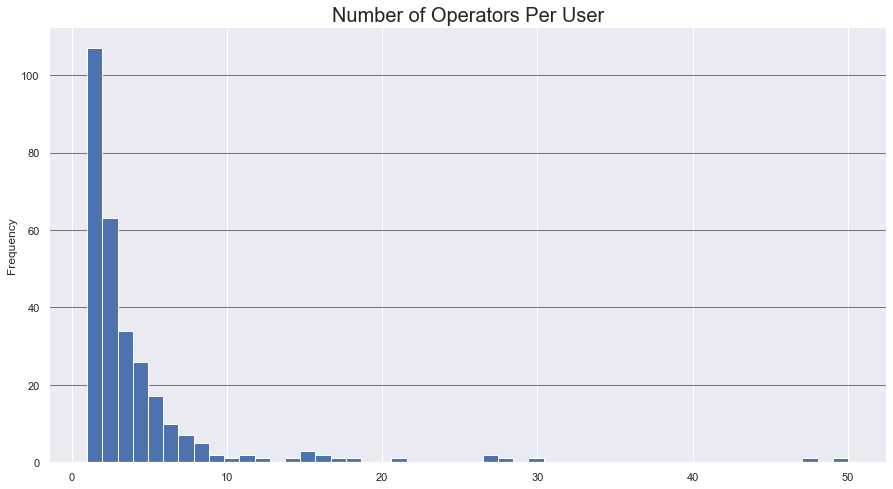

In [366]:
ax = df.groupby('user_id').operator_id.nunique().plot(figsize=(15,8), kind='hist',bins=50)
ax.set_title('Number of Operators Per User', fontsize=20)
ax.grid(axis='y', color='black', alpha=0.5)
plt.show()

As we can see, most clients have less than 5 operators and only a few clients have more than 10 operators out of  the 290 clients.

### Calls per client

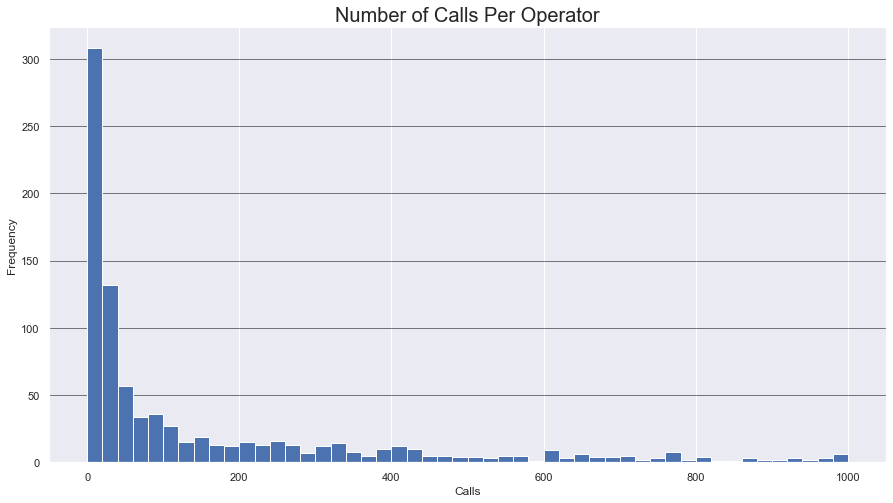

In [367]:
ax = df.groupby('operator_id')['calls_count'].sum().plot(figsize=(15,8), kind='hist', bins=50,range=(0,1000))
ax.set_title('Number of Calls Per Operator', fontsize=20)
ax.grid(axis='y', color='black', alpha=0.5)
ax.set_xlabel('Calls')
plt.show()

Most clients' operator made less than 100 calls.

### Plan costs

In [368]:
#Create a dataframe for the plan cost
plans_df = pd.DataFrame({'plan': ['A', 'B', 'C'],
                         'montly_cost': [5000, 2000, 1000],
                         'cost_internal': [.1, .15, .3],
                         'cost_external':[.4, .5, .7],
                         'mins_included': [2000, 2000, 2000]})

We created a data frame to lists the plan costs. `Plan A` is the cheapest upfront but had the cheapest `cost_internal` and `cost_external`. `Plan C` has the cheapest cost upfront but the highest overall cost. All plans comes with ***2000 mins*** internal calls.

### Calculate the total cost for the client's current plan

In [369]:
#calculate total monthly cost per user_id 

#aggregate monthly operator count per user_id
df_operator = df[['user_id','month','operator_id']]
df_operator = df_operator.groupby(['user_id','month']).nunique().reset_index()
df_operator.columns = ['user_id','month','operator_id_unique_cnt']

# aggregate the usage information at user_id level
#filter the usage df into out call/internal and out call/external
# Look at the users that made outgoing calls and the call was internal
df_out_int = df[(df['direction']=='out') & (df['internal']==True)]

# Look at the users that made outgoing calls and not an internal call
df_out_ext = df[(df['direction']=='out') & (df['internal']==False)]

# Users that only made incoming calls
df_in_intext = df[(df['direction']=='in') ]

# Extract the columns that we need
cols_to_retain =['user_id','month','call_duration']
df_out_int = df_out_int[cols_to_retain]
df_out_int.columns = ['user_id','month','call_duration_internal']

# Extract the columns that we need
df_out_ext = df_out_ext[cols_to_retain]
df_out_ext.columns = ['user_id','month','call_duration_external']

# Extract the columns that we need
df_in_intext = df_in_intext[cols_to_retain]
df_in_intext.columns = ['user_id','month','call_duration_incoming']


#Calculate the total for internal calls and external calls per user per billing month
df_out_int_agg = df_out_int.groupby(['user_id','month']).sum().reset_index()
df_out_ext_agg = df_out_ext.groupby(['user_id','month']).sum().reset_index()
df_in_intext_agg = df_in_intext.groupby(['user_id','month']).sum().reset_index()

#merge agg internal/external calls as single row
#print(df_out_int_agg.shape, df_out_ext_agg.shape,) 
df_out_agg = pd.merge(df_out_int_agg, df_out_ext_agg, how='outer', on =['user_id','month'])
#print(df_out_agg.shape,)#sanity check

#print(df_out_agg.shape, df_in_intext_agg.shape,)
df_out_agg = pd.merge(df_out_agg, df_in_intext_agg, how='outer', on =['user_id','month'])

#fillna with 0 for the usage
df_out_agg['call_duration_internal'] = df_out_agg['call_duration_internal'].fillna(0)
df_out_agg['call_duration_external'] = df_out_agg['call_duration_external'].fillna(0)
df_out_agg['call_duration_incoming'] = df_out_agg['call_duration_incoming'].fillna(0)



We created 2 different dataframes to separate external calls and internal calls and created a count for operator. We then calculated the total for both and merge the 2 dataframes together.

In [370]:
# leftjoin the plan information as extra column
df_out_agg = pd.merge( df_out_agg ,clients_df[['user_id','tariff_plan']], how='left', on='user_id' )
#print(df_out_agg.shape,)

# Merge usage df with the plan df to look at the costs per user
df_out_agg = pd.merge( df_out_agg ,plans_df, how='left', left_on='tariff_plan',right_on='plan' )
#print(df_out_agg.shape,)

#Delete column tariff plan
del df_out_agg['tariff_plan']

#print(df_out_agg.shape,)

# Merge df with the operator df 
df_out_agg = pd.merge( df_out_agg ,df_operator, how='left', on=['user_id','month'] )


We then merge the previous data frame to the `clients_df` to match users with their plan.

In [371]:
# calculate over usage cost for internal outgoing minutes
df_out_agg['call_duration_internal_over'] = df_out_agg['call_duration_internal'].\
                                                    apply(lambda x: 0 if x <=2000 else x-2000)
df_out_agg['call_cost_out_internal'] = df_out_agg['call_duration_internal_over'] * df_out_agg['cost_internal'] 

# calculate usage cost for external outgoing minutes 
df_out_agg['call_cost_out_external'] = df_out_agg['call_duration_external'] * df_out_agg['cost_external'] 

# calculate monthly operator cost
df_out_agg['call_cost_operator'] = df_out_agg['operator_id_unique_cnt'] * 100

# calculate the final invoice amount by combining baseplan + other costs
df_out_agg['total_cost'] = df_out_agg['montly_cost'] \
                            + df_out_agg['call_cost_out_internal'] \
                            + df_out_agg['call_cost_out_external'] \
                            + df_out_agg['call_cost_operator'] 


We calculated the over usage cost for internal calls and then we calculated internal,external and operator cost. We added all these to get the total cost for the current plan. Let's look at how the plans are distributed among users.

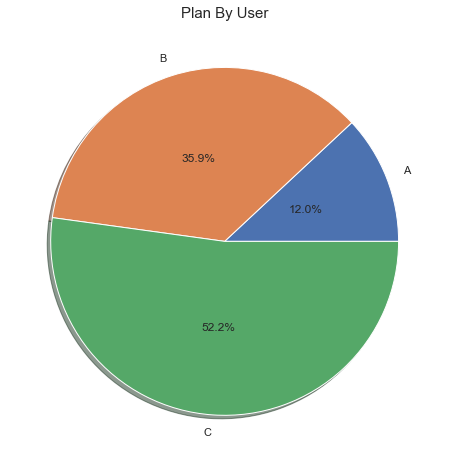

In [372]:
ax= df_out_agg.groupby('plan')['user_id'].count().plot(y='user_id', kind='pie',figsize=(8,8), autopct='%1.1f%%'\
                                                       ,pctdistance=0.5, shadow=True)
plt.title('Plan By User',fontsize=15)
plt.ylabel("")
plt.show()

`Plan C` has the most clients with _52%_ followed by `Plan B` with _36%_ and `Plan A` have the least client with _12%_

In [373]:
#look at the total cost per month
df_out_agg.groupby('month')\
.agg({'user_id':'count', 'operator_id_unique_cnt':'sum', 'total_cost':'sum'}).round(2)

user_id  operator_id_unique_cnt  total_cost
month                                                  
2019-08-01       68                     162  1138655.60
2019-09-01      159                     449  4252649.25
2019-10-01      240                     766  6292953.90
2019-11-01      244                     772  5480366.95

The company acquired more users and operators as the month progresses. The `total_cost` are listed above. October generated the most revenue out of the 4 months. Now let's look at the cost if the client choose the cheapest plan which is `Plan C`.

In [374]:
#Copy the df to see if changing plan to a cheaper plan changes the revenue 
opt_plan = df_out_agg.copy()

#Drop columns not needed
opt_plan = opt_plan.drop(['total_cost','cost_internal','montly_cost','cost_external','call_cost_out_internal'\
             ,'call_cost_out_external','mins_included'], axis=1)

In [375]:
#Set an optimal plan which is the cheapest plan out of the 3
def set_opt(plan):
    if plan == 'A':
        return 'C'
    else:
        return 'C'
opt_plan['diff_plan'] =opt_plan['plan'].apply(set_opt)

In [376]:
# Delete the plan column to reflect the plan change
del opt_plan['plan']

In [377]:
#Merge the opt plan to the plans df so we can calculate the costs
opt_plan = pd.merge(opt_plan, plans_df, how='left', left_on='diff_plan',right_on='plan')

In [378]:
#Calculate the costs and the total costs with the optimal plan
opt_plan['call_cost_out_internal'] = opt_plan['call_duration_internal_over'] * opt_plan['cost_internal'] 

# calculate usage cost for, external outgoing minutes 
opt_plan['call_cost_out_external'] = opt_plan['call_duration_external'] * opt_plan['cost_external'] 


opt_plan['diff_plan_cost'] = opt_plan['montly_cost'] \
                            + opt_plan['call_cost_out_internal'] \
                            + opt_plan['call_cost_out_external'] \
                            + opt_plan['call_cost_operator'] 



In [379]:
#Only use the columns needed
cols_to_keep = ['user_id', 'month', 'diff_plan', 'diff_plan_cost']
#opt_plan = [['user_id', 'month', 'diff_plan', 'diff_plan_cost']]
opt_plan = opt_plan[cols_to_keep]
opt_plan.head()

user_id      month diff_plan  diff_plan_cost
0   166377 2019-08-01         C         46977.6
1   166377 2019-09-01         C         62816.6
2   166377 2019-10-01         C         60610.8
3   166377 2019-11-01         C         52688.3
4   166391 2019-08-01         C          1200.0

In [380]:
#Merge the 2 data frames to see compare the cost between the original plan and the optimal plan
df3 = pd.merge(df_out_agg, opt_plan,how='inner', on=['user_id', 'month'])


In [381]:
#Only select the columns needed
cols_to_keep = ['user_id','month','call_duration_internal','call_duration_external','call_duration_incoming','plan',\
                'mins_included','operator_id_unique_cnt', 'call_duration_internal_over',\
               'total_cost','diff_plan','diff_plan_cost']
df3 = df3[cols_to_keep]
df3.head()

user_id      month  call_duration_internal  call_duration_external  \
0   166377 2019-08-01                    10.0                 64968.0   
1   166377 2019-09-01                     0.0                 87738.0   
2   166377 2019-10-01                     2.0                 84444.0   
3   166377 2019-11-01                   120.0                 73269.0   
4   166391 2019-08-01                     0.0                     0.0   

   call_duration_incoming plan  mins_included  operator_id_unique_cnt  \
0                  1296.0    B           2000                       5   
1                  1465.0    B           2000                       4   
2                  2291.0    B           2000                       5   
3                  2384.0    B           2000                       4   
4                   243.0    C           2000                       2   

   call_duration_internal_over  total_cost diff_plan  diff_plan_cost  
0                          0.0     34984.0         C         46977.6  
1                          0.0     46269.0         C         62816.6  
2                          0.0     44722.0         C         60610.8  
3                          0.0     39034.5         C         52688.3  
4                          0.0      1200.0         C          1200.0

In [382]:
plan_diff = df3.groupby('month')\
.agg({'user_id':'count', 'operator_id_unique_cnt':'sum', 'total_cost':'sum', 'diff_plan_cost':'sum'})\
.round(1).reset_index()
plan_diff

month  user_id  operator_id_unique_cnt  total_cost  diff_plan_cost
0 2019-08-01       68                     162   1138655.6       1636075.5
1 2019-09-01      159                     449   4252649.2       5858291.3
2 2019-10-01      240                     766   6292953.9       8628694.2
3 2019-11-01      244                     772   5480366.9       7378254.0

In [383]:
plan_diff['cost_diff'] = plan_diff['diff_plan_cost'] - plan_diff['total_cost']
plan_diff

month  user_id  operator_id_unique_cnt  total_cost  diff_plan_cost  \
0 2019-08-01       68                     162   1138655.6       1636075.5   
1 2019-09-01      159                     449   4252649.2       5858291.3   
2 2019-10-01      240                     766   6292953.9       8628694.2   
3 2019-11-01      244                     772   5480366.9       7378254.0   

   cost_diff  
0   497419.9  
1  1605642.1  
2  2335740.3  
3  1897887.1

As we can see the cheapest plan is not necessarily the cheapest.In fact, it cost the user more. The difference in costs varies throughout the months. The difference in total cost is at the highest in the month of October and the lowest in the month of August. August is the lowest because there was less users.Now let's only look at the active clients.

In [384]:
#Look only at the active clients that are active for the past month
active_date = df3['month'].max()
active_clients = df3[(df3['month'] >= active_date)]

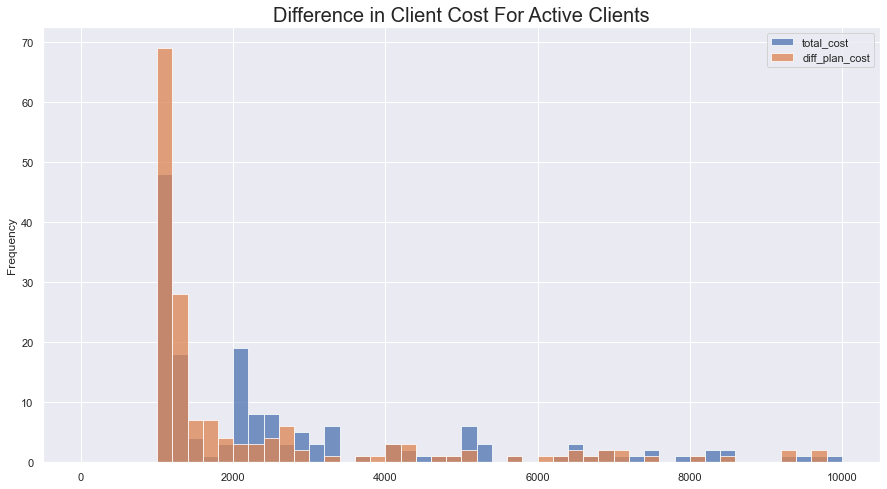

In [385]:
ax = active_clients.groupby('user_id').agg({'total_cost': 'sum', 'diff_plan_cost':'sum'})\
.plot(figsize=(15,8),kind='hist',alpha= .75,bins=50, range=(0,10000))
ax.set_title('Difference in Client Cost For Active Clients', fontsize=20)
plt.show()


The company can generate more revenue if the clients change to `Plan C` as it is the cheapest basic plan but the most expensive `cost_internal` and `cost_external` out of the plans.

In [386]:
#active_clients.info()
active_clients['cost_diff'] = active_clients['diff_plan_cost'] - active_clients['total_cost']

In [387]:
active_clients.groupby('month')\
.agg({'user_id':'count', 'operator_id_unique_cnt':'sum', 'total_cost':'sum', 'diff_plan_cost':'sum','cost_diff':'sum'})\
.round(2).reset_index()

month  user_id  operator_id_unique_cnt  total_cost  diff_plan_cost  \
0 2019-11-01      244                     772  5480366.95       7378254.0   

    cost_diff  
0  1897887.05

### Test hypothesis whether the current plan cost and cheapest plan cost are the same for all clients

> - **$H_{0}$** -Null Hypothesis- The total cost between the current plan and the cheapest plan are the same for all clients
> - **$H_{1}$** -Alternative Hypothesis- The total cost between the current plan and the cheapest plan are not the same for all clients
> - alpha = .05 - if the p-value is less than alpha, we reject the hypothesis

In [388]:
alpha = 0.05
results = st.mannwhitneyu(df3['total_cost'], df3['diff_plan_cost'])

print('p-value: ', results.pvalue.round(4))

if results.pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis") 

p-value:  0.0013
Reject the null hypothesis


We reject the null hypothesis as the p value is less than the alpha. There was a significant difference between all clients' current plans cost and the cheapest plan cost.

### Test hypothesis whether the current plan cost and cheapest plan cost are the same for active clients

> - **$H_{0}$** -Null Hypothesis- The total cost between the current plan and the cheapest plan are the same for active clients
> - **$H_{1}$** -Alternative Hypothesis- The total cost between the current plan and the cheapest plan are not the same for active clients
> - alpha = .05 - if the p-value is less than alpha, we reject the hypothesis

In [389]:
alpha = 0.05
results = st.mannwhitneyu(active_clients['total_cost'], active_clients['diff_plan_cost'])

print('p-value: ', results.pvalue.round(4))

if results.pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis") 

p-value:  0.0728
Failed to reject the null hypothesis


We failed to reject the null hypothesis as the p value is greater than the alpha. There was not a significant difference between active clients' current plans cost and the cheapest plan cost.

## Conclusion

Initial review and preprocessing:
- There are about 53902 mobile user logs
- There are 8172 missing values under `operator_ID` column and 117 missing values under `internal column`
- We have 4900 duplicate entries which is 9% of the data. The duplicate entries are not that many so we decided to drop them
- We changed the columns to their right data types
- Replaced missing values using ***ffill*** and ***bfill** and deleted the rest
- Column `is_missed_call` showing inaccurate `call_duration`, so we fixed it 

Plans Data:
- There were not a lot of user activities in the month of August. Calls increased by October and it continued until November with the highest activity at the end of November
- Most clients have less than 5 operators and only a few clients have more than 10 operators out of  the 290 clients
-`Plan C` has the most clients with _52%_ followed by `Plan B` with _36%_ and `Plan A` have the least client with _12%_
- `Plan A` is the the most expensive upfront but had the cheapest `cost_internal` and `cost_external`
- `Plan C` has the cheapest cost upfront but the highest overall cost
- All plans comes with ***2000 mins*** internal calls
- Most users go over their internal calls minutes
- October generated the most revenue out of the 4 months
 
Looking closely at our data and calculations, we found out that:
 - The cheapest plan is not necessarily the cheapest and in fact, it costs the user more
 - The difference in total cost is at the highest in the month of October and the lowest in the month of August 
 - August is the lowest because there was less users
 
Hypothesis Test: Conducted a test to see if there is statistically significant difference between clients current plan and the cheapest plan
- There was a significant difference between all clients' current plans cost and the cheapest plan cost
- There was not a significant difference between the current plan and the cheapest plan with active clients

Based on our analysis, ***Plan C***  is the plan that is going to bring in the most revenue if we take all clients into account. Although it is the cheapest out of all the three plans, the total call cost per minute for all clients is higher if they switch to this plan and in return more revenue for the company.
Looking only at the active clients, there was not a significant difference in cost between the current plans and the cheapest plan. Also taking the cost difference between the plans into consideration, it's best for the company to keep the clients on their current plan as most of the clients are under ***Plan C***.

Dashboard Link: https://public.tableau.com/app/profile/francis3907/viz/TelecomFinal/TelecomLog